In [ ]:
!pip install ta
!pip install requests pandas numpy matplotlib ta
!pip install pandas numpy matplotlib scikit-learn requests scipy SQLAlchemy
!pip install statsmodels
!pip install dash


Fetching data for Bitcoin...
Fetched 91 records for Bitcoin.

Fetching data for Ethereum...
Fetched 91 records for Ethereum.

Fetching data for Litecoin...
Fetched 91 records for Litecoin.

Processing Bitcoin...


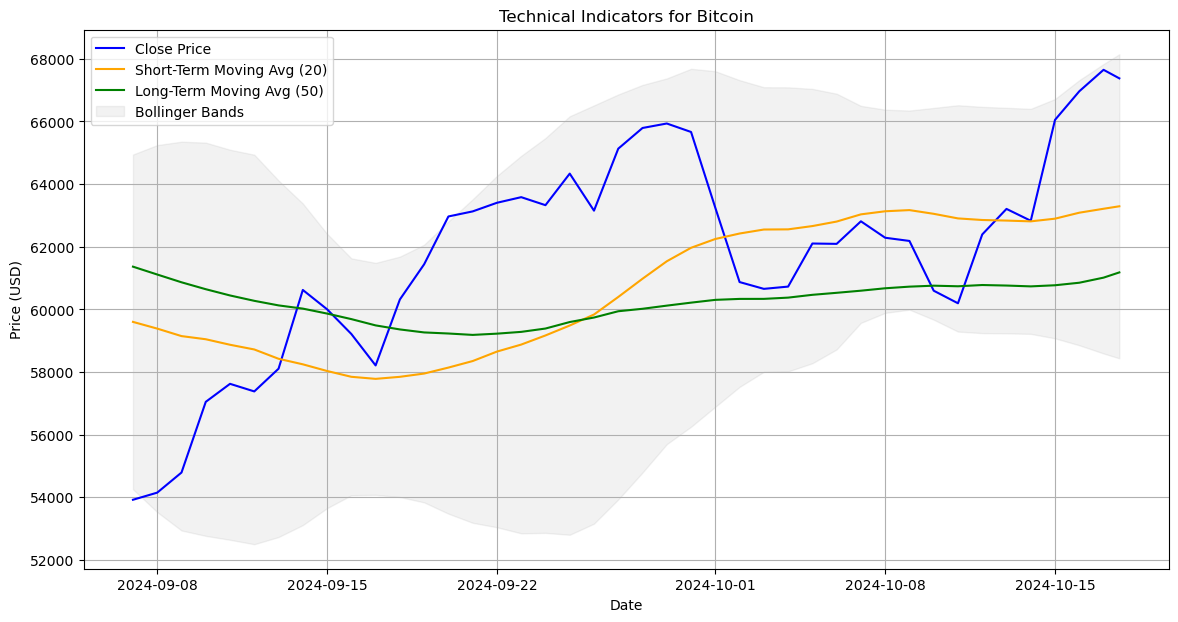

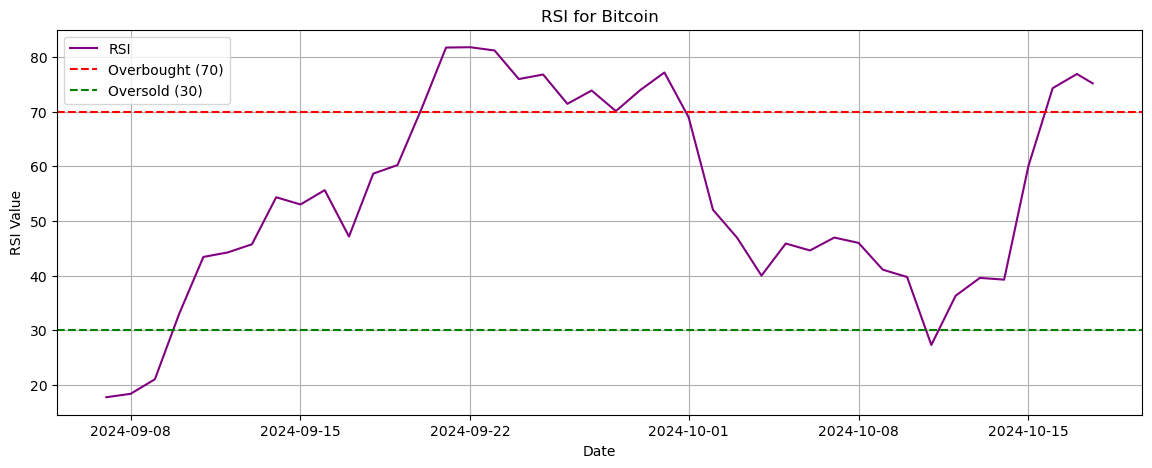

Trend data for Bitcoin saved to bitcoin_forecast_rates.csv
Trend data for Bitcoin saved to SQL database.
Not enough data to generate forecast for Bitcoin.
Forecast CSV data for Bitcoin inserted into 'crypto_forecast_csvs' table.

Processing Ethereum...


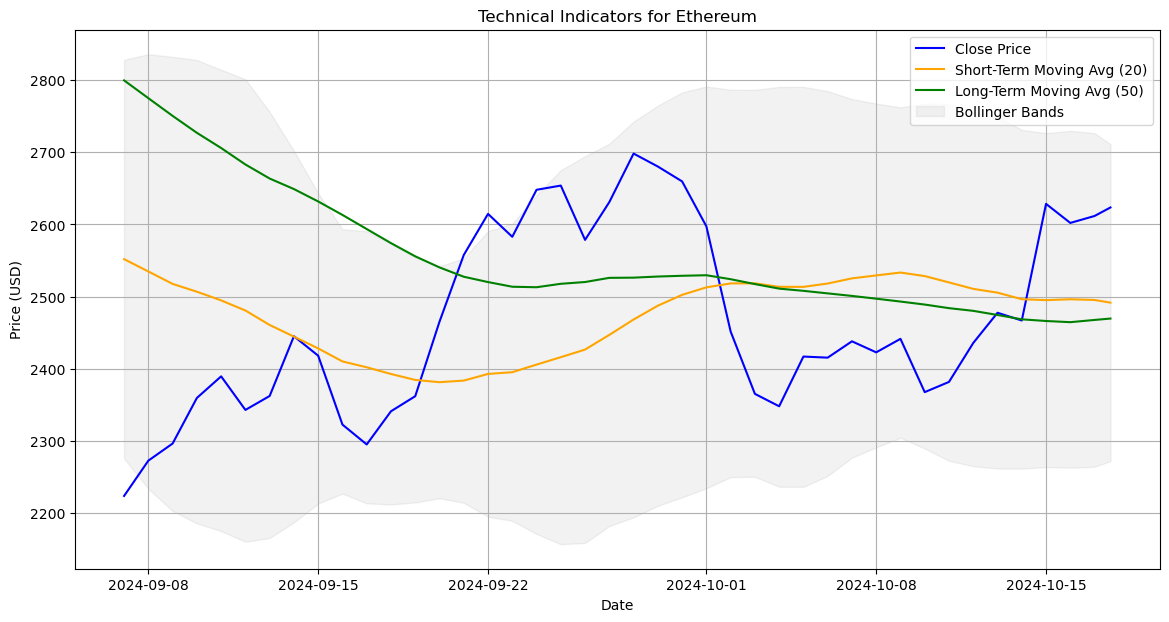

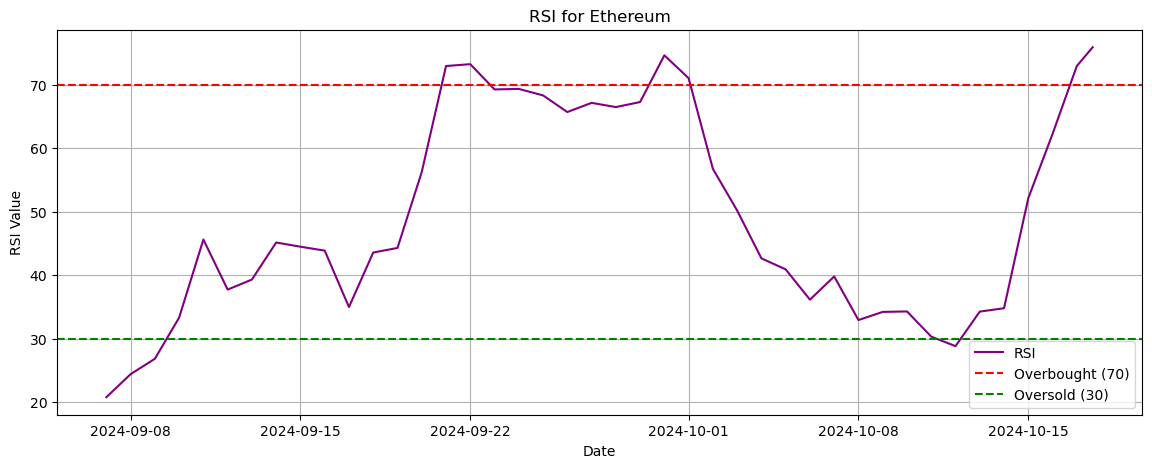

Trend data for Ethereum saved to ethereum_forecast_rates.csv
Trend data for Ethereum saved to SQL database.
Not enough data to generate forecast for Ethereum.
Forecast CSV data for Ethereum inserted into 'crypto_forecast_csvs' table.

Processing Litecoin...


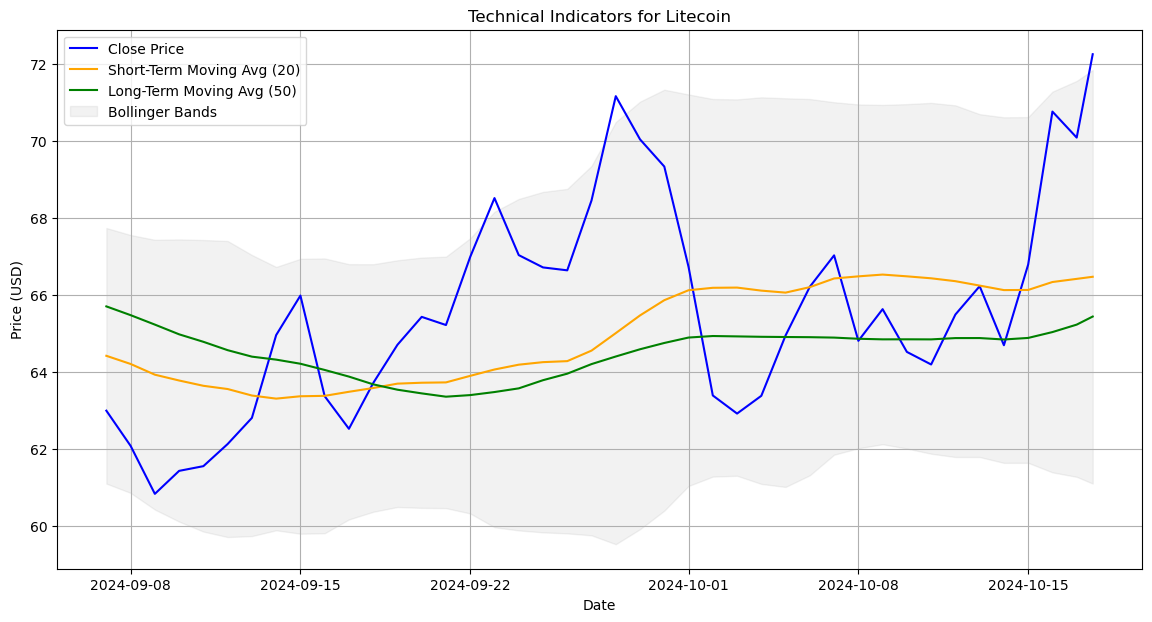

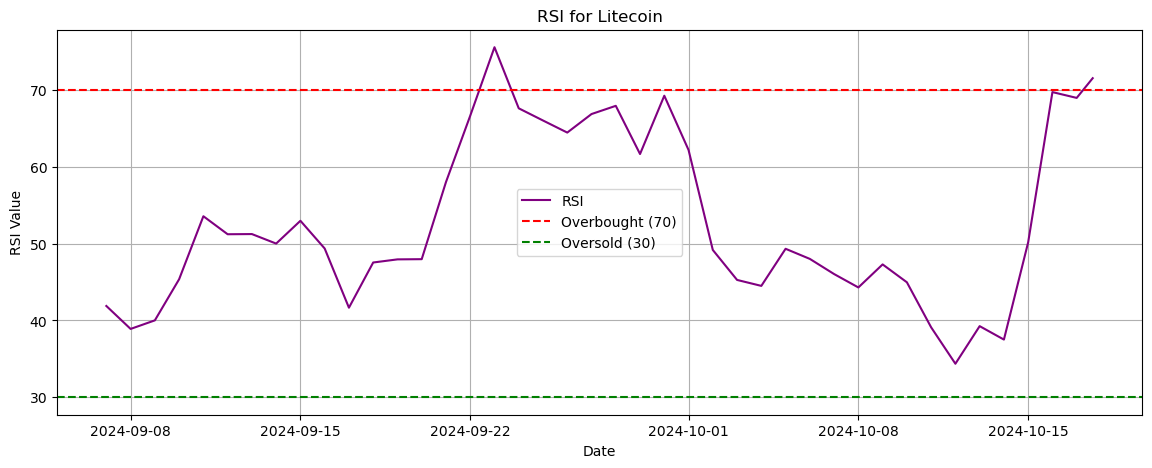

Trend data for Litecoin saved to litecoin_forecast_rates.csv
Trend data for Litecoin saved to SQL database.
Not enough data to generate forecast for Litecoin.
Forecast CSV data for Litecoin inserted into 'crypto_forecast_csvs' table.
Exchange rates exported to SQL database.

Combined Crypto Data:
           Cryptocurrency         Close
Date                                   
2024-07-20        bitcoin  66689.548807
2024-07-21        bitcoin  67206.064706
2024-07-22        bitcoin  68088.139963
2024-07-23        bitcoin  67607.713399
2024-07-24        bitcoin  65942.417465
Combined crypto data exported to SQL database.

All tasks completed successfully.
SQL connection terminated.


In [193]:
import hashlib
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sqlalchemy import create_engine
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# =========================
# Configuration and Settings
# =========================
cryptocurrencies = {
    'bitcoin': 'bitcoin',
    'ethereum': 'ethereum',
    'litecoin': 'litecoin'
}

SMA_SHORT = 20
SMA_LONG = 50
RSI_PERIOD = 14
PREDICTION_DAYS = 7

SHORT_TERM_MA = 'Short-Term Moving Avg'
LONG_TERM_MA = 'Long-Term Moving Avg'

DATABASE_TYPE = 'mssql'
DBAPI = 'pyodbc'
SERVER = 'MARTIN'
DATABASE = 'crypto_data'
DRIVER = 'ODBC Driver 17 for SQL Server'
DATABASE_URI = f"{DATABASE_TYPE}+{DBAPI}://@{SERVER}/{DATABASE}?driver={DRIVER.replace(' ', '+')}&trusted_connection=yes"
engine = create_engine(DATABASE_URI, echo=False)

# =========================
# Utility Functions
# =========================
def get_hash(data):
    """Generates a SHA-256 hash for the given data."""
    hash_object = hashlib.sha256(data.encode())
    return hash_object.hexdigest()

# =========================
# Data Cleaning Function
# =========================
def clean_crypto_data(df):
    """
    Cleans the cryptocurrency data by handling missing values, duplicates,
    and ensuring proper data types for analysis.
    """
    df = df.drop_duplicates()
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df = df.fillna(method='ffill')
    
    if df.index.dtype != 'datetime64[ns]':
        df.index = pd.to_datetime(df.index)
    
    if df.index.freq is None:
        df = df.asfreq('D')
        df = df.fillna(method='ffill').fillna(method='bfill')
    
    df = df[(df['Close'].notnull()) & (df['Close'] > 0)]
    print(f"Data cleaned. Remaining rows: {len(df)}")
    return df

# =========================
# Data Fetching Functions
# =========================
def fetch_crypto_data(crypto_id, vs_currency='usd', days='60'):
    """Fetches historical market data for a cryptocurrency from CoinGecko."""
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart'
    params = {'vs_currency': vs_currency, 'days': days, 'interval': 'daily'}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if 'prices' not in data:
            print(f"Error: 'prices' key not found in the response for '{crypto_id}'. Response: {data}")
            return pd.DataFrame()

        prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        prices['Date'] = pd.to_datetime(prices['timestamp'], unit='ms')
        prices.set_index('Date', inplace=True)
        prices['Close'] = prices['price']
        prices = prices[['Close']].sort_index()

        return prices

    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error for '{crypto_id}': {e}")
        return pd.DataFrame()

def fetch_all_crypto_data():
    """Fetches historical data for all specified cryptocurrencies."""
    crypto_data = {}
    for crypto_name, crypto_id in cryptocurrencies.items():
        print(f"\nFetching data for {crypto_name.capitalize()}...")
        prices = fetch_crypto_data(crypto_id, days='90')
        if prices.empty:
            print(f"No data available for {crypto_name.capitalize()}. Skipping...")
            continue
        crypto_data[crypto_name] = prices
        print(f"Fetched {len(prices)} records for {crypto_name.capitalize()}.")
    return crypto_data

# =========================
# Technical Analysis Functions
# =========================
def perform_technical_analysis(df):
    """Applies technical indicators to the DataFrame."""
    df = df.copy()
    df[SHORT_TERM_MA] = df['Close'].rolling(window=SMA_SHORT).mean()
    df[LONG_TERM_MA] = df['Close'].rolling(window=SMA_LONG).mean()
    df['RSI'] = compute_rsi(df['Close'], window=RSI_PERIOD)
    df['Bollinger_High'], df['Bollinger_Low'] = compute_bollinger_bands(df['Close'])
    
    df.dropna(subset=[SHORT_TERM_MA, LONG_TERM_MA, 'RSI', 'Bollinger_High', 'Bollinger_Low'], inplace=True)
    return df

def compute_rsi(series, window=14):
    """Computes the Relative Strength Index (RSI) for a given series."""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_bollinger_bands(series, window=20, window_dev=2):
    """Computes Bollinger Bands for a given series."""
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    upper_band = rolling_mean + (rolling_std * window_dev)
    lower_band = rolling_mean - (rolling_std * window_dev)
    return upper_band, lower_band

def identify_trends(df):
    """Identifies upward and downward trends based on technical indicators."""
    df = df.copy()
    df['Trend'] = 'Neutral'
    df.loc[df[SHORT_TERM_MA] > df[LONG_TERM_MA], 'Trend'] = 'Uptrend'
    df.loc[df[SHORT_TERM_MA] < df[LONG_TERM_MA], 'Trend'] = 'Downtrend'
    df['RSI_Status'] = 'Neutral'
    df.loc[df['RSI'] > 70, 'RSI_Status'] = 'Overbought'
    df.loc[df['RSI'] < 30, 'RSI_Status'] = 'Oversold'
    return df
# =========================
# Forecasting Function
# =========================
def generate_forecast(df, crypto_name, prediction_days=PREDICTION_DAYS):
    """Generates a forecast using ARIMA model."""
    # Ensure there is enough data
    if len(df) < SMA_LONG:  # At least as many data points as the longest moving average window
        print(f"Not enough data to generate forecast for {crypto_name.capitalize()}.")
        return

    # Prepare the data for the ARIMA model
    df = df.copy()
    df['Close'] = df['Close'].astype(float)  # Ensure 'Close' is in float

    # Infer or set the frequency for the date index
    if df.index.freq is None:
        df = df.asfreq('D')  # Set to daily frequency ('D')
    
    # Handle missing data after setting frequency
    df = df.fillna(method='ffill')
    
    # Fit the ARIMA model
    try:
        model = ARIMA(df['Close'], order=(5, 1, 0))  # ARIMA(p=5, d=1, q=0)
        model_fit = model.fit()
    except Exception as e:
        print(f"ARIMA model failed for {crypto_name.capitalize()}: {e}")
        return

    # Forecast future prices
    try:
        forecast = model_fit.forecast(steps=prediction_days)
    except Exception as e:
        print(f"Forecasting failed for {crypto_name.capitalize()}: {e}")
        return
    
    # Set forecast dates with proper frequency
    forecast_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=prediction_days, freq='D')

    # Plot forecast
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Historical Close', color='blue')
    plt.plot(forecast_dates, forecast, label=f'{crypto_name.capitalize()} Forecast', color='red', linestyle='--')
    plt.title(f"{crypto_name.capitalize()} Price Forecast for Next {prediction_days} Days")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate and print the RMSE (Root Mean Squared Error)
    try:
        history_len = len(df['Close'])
        prediction_len = min(history_len, 30)  # Take the last 30 data points for RMSE calculation
        past_values = df['Close'].values[-prediction_len:]
        predictions = model_fit.predict(start=history_len - prediction_len, end=history_len - 1)
        rmse = np.sqrt(mean_squared_error(past_values, predictions))
        print(f"RMSE for {crypto_name.capitalize()}: {rmse}")
    except Exception as e:
        print(f"RMSE calculation failed for {crypto_name.capitalize()}: {e}")

    # Export forecast to SQL Database
    try:
        forecast_df = pd.DataFrame({
            'Date': forecast_dates,
            'Predicted_Price': forecast.values,
            'Crypto': crypto_name.capitalize()
        })
        forecast_df.to_sql('crypto_forecasts', con=engine, if_exists='append', index=False)
        print(f'Future predictions for {crypto_name.capitalize()} exported to SQL database.')
    except Exception as e:
        print(f"Failed to export forecast for {crypto_name.capitalize()} to SQL database: {e}")

    # Export forecast to CSV (optional, already handled in main loop)
    # forecast_df.to_csv(f"{crypto_name}_forecast_rates.csv", index=False)

# =========================
# Additional Functions
# =========================
def plot_technical_indicators(df, crypto_name):
    """Plots the technical indicators for the given cryptocurrency."""
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.plot(df.index, df[SHORT_TERM_MA], label=f'Short-Term Moving Avg ({SMA_SHORT})', color='orange')
    plt.plot(df.index, df[LONG_TERM_MA], label=f'Long-Term Moving Avg ({SMA_LONG})', color='green')
    plt.fill_between(df.index, df['Bollinger_Low'], df['Bollinger_High'], color='grey', alpha=0.1, label='Bollinger Bands')
    plt.title(f"Technical Indicators for {crypto_name.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

def plot_rsi(df, crypto_name):
    """Plots the RSI for the given cryptocurrency."""
    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
    plt.title(f"RSI for {crypto_name.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid()
    plt.show()

def fetch_exchange_rates():
    """Fetches exchange rates for cryptocurrencies against FIAT currencies and exports to SQL."""
    FIAT_CURRENCIES = ['usd', 'eur', 'jpy', 'gbp', 'aud']  # Use lowercase for CoinGecko
    url = 'https://api.coingecko.com/api/v3/simple/price'
    crypto_ids = ','.join(cryptocurrencies.values())
    params = {
        'ids': crypto_ids,
        'vs_currencies': ','.join(FIAT_CURRENCIES)
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        # Convert the response to a DataFrame
        exchange_rates = pd.json_normalize(data).T.reset_index()

        # Dynamically adjust columns based on the number of currencies retrieved
        fiat_columns = ['Crypto'] + FIAT_CURRENCIES[:len(exchange_rates.columns) - 1]
        exchange_rates.columns = fiat_columns

        exchange_rates['Crypto'] = exchange_rates['Crypto'].str.capitalize()

        # Export to SQL Database
        exchange_rates.to_sql('exchange_rates', con=engine, if_exists='append', index=False)
        print('Exchange rates exported to SQL database.')

        return data
    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error while fetching exchange rates: {e}")
        return None

def display_data_as_table(data_dict):
    """Displays the dataset as a table and exports to SQL Database."""
    # Concatenate all DataFrames into a single DataFrame for display
    combined_df = pd.concat(data_dict.values(), keys=data_dict.keys())
    combined_df = combined_df.reset_index(level=0).rename(columns={'level_0': 'Cryptocurrency'})
    print("\nCombined Crypto Data:")
    print(combined_df.head())

    # Export combined data to SQL Database
    combined_df.reset_index(inplace=True)
    combined_df.rename(columns={'level_0': 'Cryptocurrency'}, inplace=True)
    try:
        combined_df.to_sql('crypto_prices', con=engine, if_exists='append', index=False)
        print('Combined crypto data exported to SQL database.')
    except Exception as e:
        print(f"Failed to export combined crypto data to SQL database: {e}")

def export_forecast_csv_to_sql(crypto_name):
    """Reads the forecast CSV file and inserts its contents into the database."""
    csv_filename = f"{crypto_name}_forecast_rates.csv"
    try:
        forecast_csv_df = pd.read_csv(csv_filename)
        forecast_csv_df.to_sql('crypto_forecast_csvs', con=engine, if_exists='append', index=False)
        print(f"Forecast CSV data for {crypto_name.capitalize()} inserted into 'crypto_forecast_csvs' table.")
    except FileNotFoundError:
        print(f"Forecast CSV file '{csv_filename}' not found. Skipping insertion.")
    except Exception as e:
        print(f"Failed to insert forecast CSV data for {crypto_name.capitalize()} into database: {e}")

# =========================
# Main Execution Flow
# =========================
if __name__ == "__main__":
    try:
        # Fetch all crypto data
        all_crypto_data = fetch_all_crypto_data()

        # Perform technical analysis, forecasting, plotting, and exporting to SQL
        for crypto, df in all_crypto_data.items():
            print(f"\nProcessing {crypto.capitalize()}...")
            analyzed_df = perform_technical_analysis(df)
            trend_identified_df = identify_trends(analyzed_df)

            # Plotting the technical indicators and RSI
            plot_technical_indicators(trend_identified_df, crypto)
            plot_rsi(trend_identified_df, crypto)

            # Save to CSV for each cryptocurrency
            csv_filename = f"{crypto}_forecast_rates.csv"
            trend_identified_df.to_csv(csv_filename)
            print(f"Trend data for {crypto.capitalize()} saved to {csv_filename}")

            # Save the CSV trend data to SQL database
            try:
                # Read the CSV file back into a DataFrame (optional, can use trend_identified_df directly if no CSV needed)
                csv_data_df = pd.read_csv(csv_filename)

                # Insert the data into the SQL database
                csv_data_df.to_sql('crypto_trend_data', con=engine, if_exists='append', index=False)
                print(f"Trend data for {crypto.capitalize()} saved to SQL database.")
            except Exception as e:
                print(f"Failed to save trend data for {crypto.capitalize()} to SQL database: {e}")

            # Forecast the cryptocurrency price for the next PREDICTION_DAYS
            generate_forecast(trend_identified_df, crypto, prediction_days=PREDICTION_DAYS)

            # Insert the forecast CSV into the database
            export_forecast_csv_to_sql(crypto)

        # Fetch exchange rates once for all cryptocurrencies
        fetch_exchange_rates()

        # Display the fetched data as a table and export to SQL
        display_data_as_table(all_crypto_data)

        print("\nAll tasks completed successfully.")

    finally:
        # Terminate the SQL connection by disposing the engine
        engine.dispose()
        print("SQL connection terminated.")
#Detailed Breakdown of Changes:
#Function export_forecast_csv_to_sql(crypto_name) Added:

def export_forecast_csv_to_sql(crypto_name):
    """Reads the forecast CSV file and inserts its contents into the database."""
    csv_filename = f"{crypto_name}_forecast_rates.csv"
    try:
        forecast_csv_df = pd.read_csv(csv_filename)
        forecast_csv_df.to_sql('crypto_forecast_csvs', con=engine, if_exists='append', index=False)
        print(f"Forecast CSV data for {crypto_name.capitalize()} inserted into 'crypto_forecast_csvs' table.")
    except FileNotFoundError:
        print(f"Forecast CSV file '{csv_filename}' not found. Skipping insertion.")
    except Exception as e:
        print(f"Failed to insert forecast CSV data for {crypto_name.capitalize()} into database: {e}")

In [194]:
import dash
from dash import dcc, html
import plotly.express as px

app = dash.Dash(__name__)

# Sample interactive price line chart function
def create_crypto_line_chart(df, crypto_name):
    return px.line(df, x=df.index, y='Close', title=f'{crypto_name.capitalize()} Price Over Time')

# Ensure all_crypto_data is defined in your actual application
# Placeholder for all_crypto_data
# all_crypto_data = {
#     'bitcoin': pd.DataFrame(...),
#     'ethereum': pd.DataFrame(...)
# }

app.layout = html.Div([
    html.H1("Cryptocurrency Data Dashboard"),
    
    # Dropdown for selecting cryptocurrency
    dcc.Dropdown(id='crypto-selector',
                 options=[{'label': name.capitalize(), 'value': name} for name in all_crypto_data.keys()],
                 value='bitcoin',  # Default value
                 style={'width': '50%'}),
    
    # Graph to display selected cryptocurrency's price data
    dcc.Graph(id='price-chart')
])

# Callback to update chart based on selected cryptocurrency
@app.callback(
    dash.dependencies.Output('price-chart', 'figure'),
    [dash.dependencies.Input('crypto-selector', 'value')]
)
def update_chart(crypto_name):
    df = all_crypto_data[crypto_name]  # Ensure this is defined before running the app
    return create_crypto_line_chart(df, crypto_name)

if __name__ == '__main__':
    app.run_server(debug=True, port=8052)  # Changed to use port 8052


In [ ]:
import seaborn as sns

def plot_correlation_heatmap(data_dict):
    """Plots a heatmap showing correlations between different cryptocurrencies."""
    # Create a DataFrame that combines closing prices for all cryptocurrencies
    combined_df = pd.DataFrame({crypto: df['Close'] for crypto, df in data_dict.items()})
    
    # Compute the correlation matrix
    correlation_matrix = combined_df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Cryptocurrency Price Correlation Heatmap')
    plt.show()

# Usage
plot_correlation_heatmap(all_crypto_data)